<a href="https://colab.research.google.com/github/AmazingK2k3/Over_Squashing_GNNs/blob/main/Bridges_Rewiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00


In [3]:
import networkx as nx

In [4]:
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



## QM9 Dataset

In [5]:
from torch_geometric.datasets import QM9

q_data = QM9(root = '/content/drive/MyDrive/qm9')

Extracting /content/drive/MyDrive/qm9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.


KeyboardInterrupt: 

In [ ]:
# from torch_geometric.datasets import Actor
# actor_data = Actor(root = '/content/drive/MyDrive/Actor')


In [ ]:
# from torch_geometric.datasets import TUDataset
# enzuymes = TUDataset(root = '/content/drive/MyDrive/Enzymes', name = 'ENZYMES')



In [ ]:
samp_data = q_data[0]
samp_data.y

In [ ]:
data = q_data[0]
print(data)

## QM9 Visualization

In [ ]:
for i in range(10):
  data = q_data[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 26, width = 2, with_labels = False)
  plt.show()

In [ ]:
len(q_data) # number of graphs

## Actor Dataset

In [ ]:
from torch_geometric.datasets import Actor
actor_data = Actor(root = '/content/drive/MyDrive/Actor')

In [ ]:
type(actor_data)

## Not able to plot the below one


In [ ]:
# G = to_networkx(actor_data)
# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
#         node_size = 26, width = 2, with_labels = False)

## Downloading Enzymes


In [6]:
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root = '/content/drive/MyDrive/Enzymes', name = 'ENZYMES')


Processing...
Done!


In [7]:
print(enzymes)

ENZYMES(600)


In [8]:
len(enzymes)

600

In [9]:
for i in range(10):
  sample = enzymes[i]
  print(sample)

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Data(edge_index=[2, 102], x=[23, 3], y=[1])
Data(edge_index=[2, 92], x=[25, 3], y=[1])
Data(edge_index=[2, 90], x=[24, 3], y=[1])
Data(edge_index=[2, 90], x=[23, 3], y=[1])
Data(edge_index=[2, 92], x=[24, 3], y=[1])
Data(edge_index=[2, 118], x=[26, 3], y=[1])
Data(edge_index=[2, 266], x=[88, 3], y=[1])
Data(edge_index=[2, 78], x=[23, 3], y=[1])
Data(edge_index=[2, 106], x=[32, 3], y=[1])


## Finding Bridges in a Graph

Graph 1


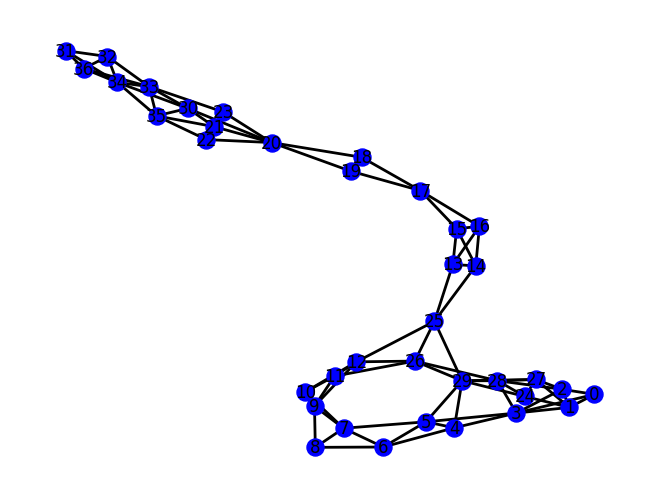

Graph 2


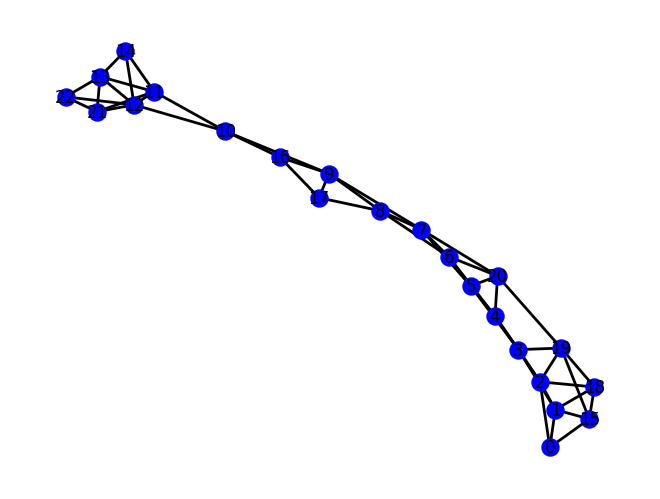

Graph 3


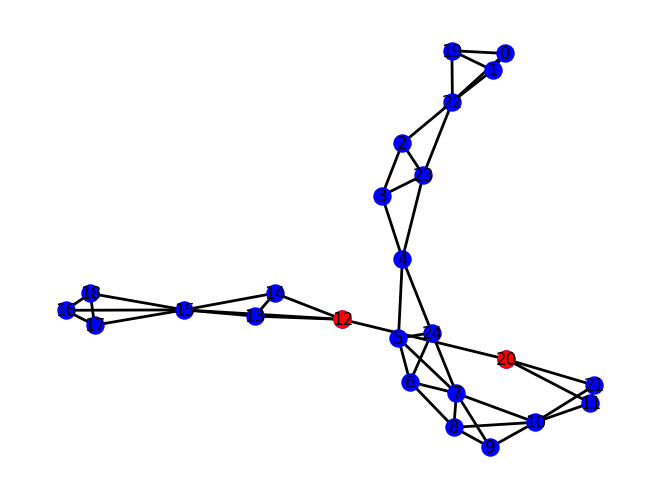

Graph 4


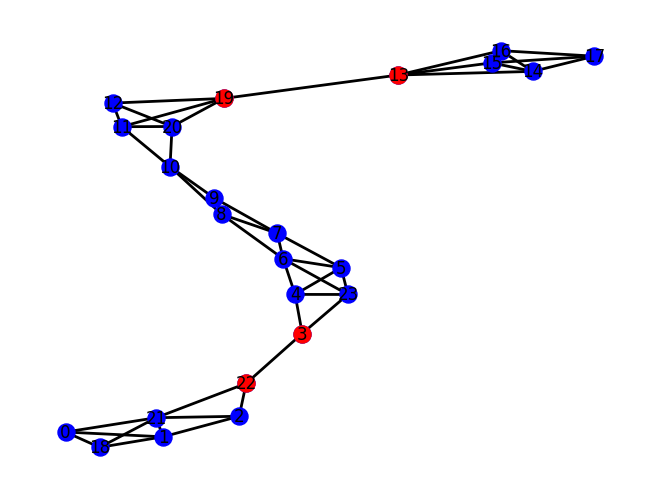

Graph 5


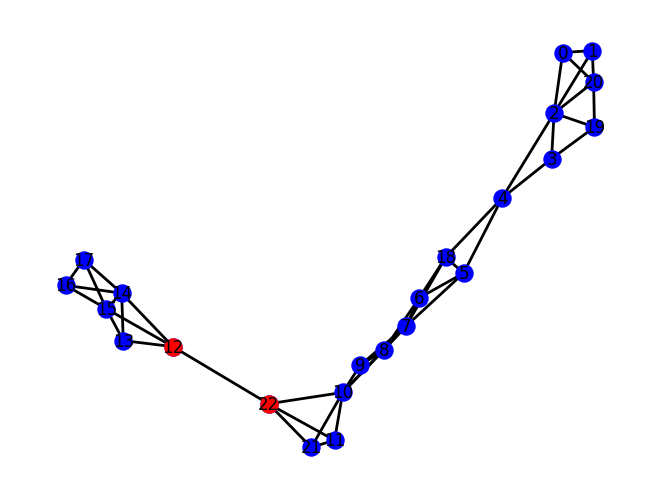

Graph 6


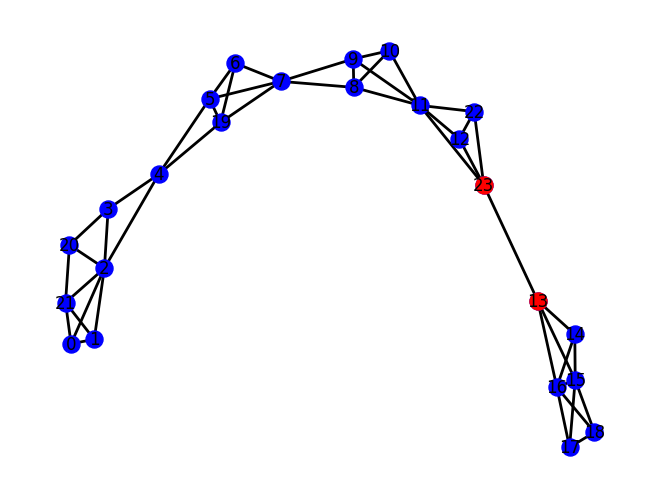

Graph 7


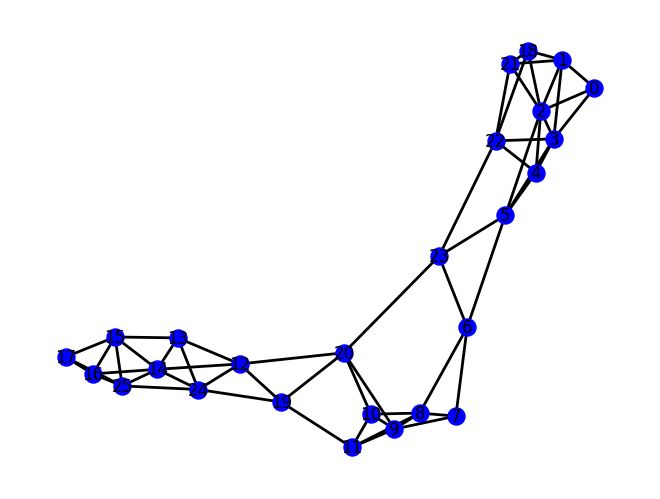

Graph 8


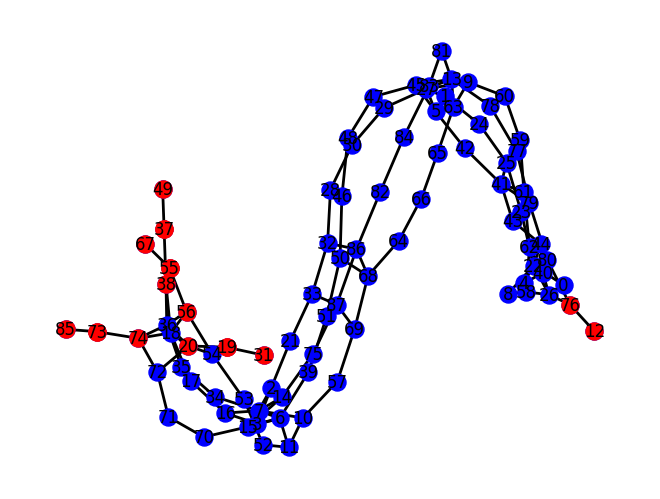

Graph 9


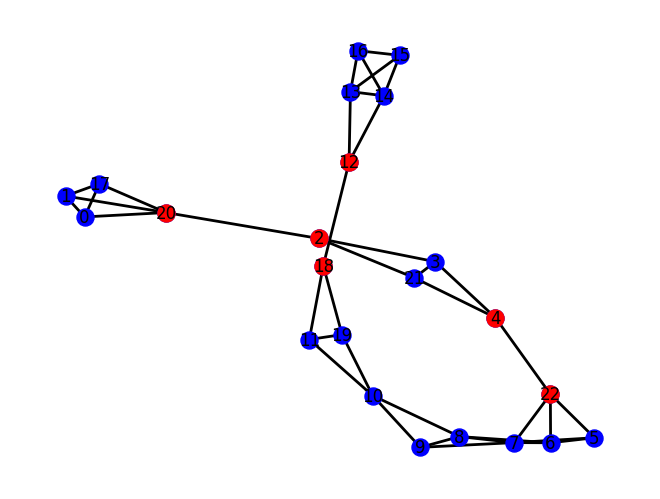

Graph 10


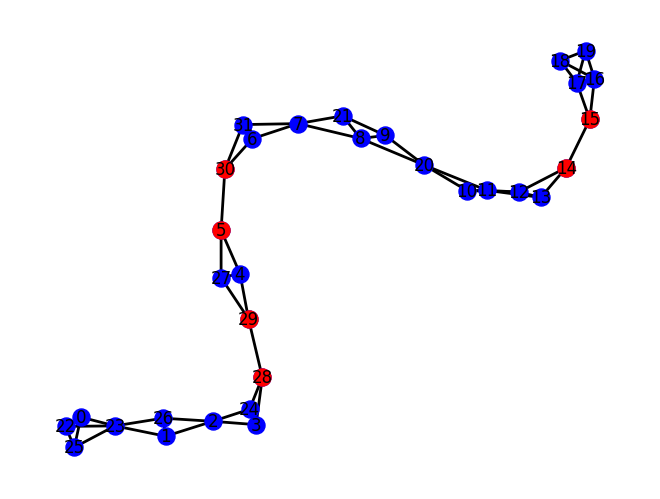

In [10]:
for i in range(10):
  data = enzymes[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)

  plt.show()

In [11]:
Gx = to_networkx(enzymes[2],to_undirected = True)
subgraph = Gx.subgraph(list(G.nodes())[:500])
#pos = nx.spring_layout(subgraph)

subgraph_bridges = list(nx.bridges(subgraph))

In [12]:
subgraph_bridges

[(12, 20)]

# Finding Adjacent Nodes to the Bridge nodes

In [ ]:
# Lets take

In [13]:
list(nx.all_neighbors(Gx,12))

[13, 14, 15, 20]

In [14]:
list(nx.all_neighbors(Gx,20))

[11, 12, 21]

In [15]:
Lx = to_networkx(enzymes[9],to_undirected = True)


In [16]:
list(nx.bridges(Lx))

[(5, 30), (14, 15), (28, 29)]

In [17]:
list(nx.local_bridges(Lx))

[(5, 30, inf), (14, 15, inf), (28, 29, inf)]

## Connect the neighbours of the bridge nodes

# Preparing the data

In [ ]:
# Lets take 1000 graphs to train.
data = enzymes

In [ ]:
data

In [ ]:
list(data)
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]



In [ ]:
print(f"Train_size, Test_Size, Val_size: {train_size}, {test_size}, {val_size}")

In [ ]:
device = torch.device('cuda ' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
def loader(batch_size):
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = 1 , shuffle = True)

  return train_loader, val_loader, test_loader

In [ ]:
num_node_features = 3

## GraphSAGE Model Definition

In [ ]:
# num_node_features is the number of node features.

from binascii import a2b_hex

from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h, num_classes):
        super().__init__()
        self.sage1 = SAGEConv(num_node_features, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_h//2)
        self.sage3 = SAGEConv(dim_h//2, dim_h//4)
        self.lin = Linear((dim_h//4), num_classes)

    def forward(self, x, edge_index, batch):
        import itertools
        edges = list(itertools.permutations(range(18),2))
        full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)

        h1 = self.sage1(x, edge_index)
        h = F.elu(h1)
        h = F.dropout(h, p=0.5, training=self.training)
        h2 = self.sage2(h, edge_index)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)
        h3 = self.sage3(h,full_adj)


        a1 = global_mean_pool(h1,batch)
        m1 = global_max_pool(h1,batch)
        a2 = global_mean_pool(h2,batch)
        m2 = global_max_pool(h2,batch)

        #h = torch.cat((a1,a2), dim = 1)
        h = global_mean_pool(h3, batch)
        x = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(x)
        #return torch.softmax(x,dim=1)
        return x


## Data-Loader

In [ ]:
def loader(batch_size):
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = 1 , shuffle = True)

  return train_loader, val_loader, test_loader

## Utility Functions

In [ ]:
def Roc_curve(labels, preds, model_name):
  fpr, tpr, thresholds = roc_curve(labels, preds)
  plt.figure(figsize = (4,4))
  plt.plot(fpr, tpr)
  plt.title(f"{model_name}")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

In [ ]:
def save_classification_report_txt(report_str, model_name, file_path):
    with open(file_path, 'w') as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report_str)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def Confusion_matrix(confmat, model_name):


    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')


    ax.set_xticklabels(['']+['Not Seizure', 'Seizure'])
    ax.set_yticklabels(['']+['Not Seizure', 'Seizure'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name}")
    # ax.xaxis.set_label_position('top')

    plt.tight_layout()

    plt.show()



def c_matplot(model, test_loader, j):
  all_labels = []
  all_preds = []
  model_name = type(model).__name__
  #model.eval()
  #with torch.no_grad():
  for data in test_loader:
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.batch = data.batch.to(device)
    data.y = data.y.to(device)

    out = model(data.x, data.edge_index, data.batch)
    out = out.squeeze()
    out = (out >= 0.5).int()
    out = out.view(-1).detach().cpu().numpy()
    all_labels.extend(data.y.cpu().numpy())
    all_preds.extend(out)

  clf_rp = classification_report(all_labels, all_preds)
  save_classification_report_txt(clf_rp, model_name, f'/content/drive/MyDrive/Classification_reports/exp{j}_{model_name}.txt')
  conf = confusion_matrix(y_true = all_labels, y_pred = all_preds)
  roc_curve = Roc_curve(all_labels, all_preds, model_name)
  return Confusion_matrix(conf, model_name),print(clf_rp), roc_curve


## Training Function

In [ ]:
def train(model, loader, lr, epochs,i):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  epochs = epochs
  model.train()

  train_accuracies = []
  val_accuracies = []
  best_val_acc = 0
  best_model_state = None
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    for data in loader:
      data.x = data.x.to(device)
      data.edge_index = data.edge_index.to(device)
      data.y = data.y.to(device).float()
      data.batch = data.batch.to(device)
      #data.y = data.y.view(-1,1)

      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      out = out.view(-1)
      #print("Before view", out)
      loss = criterion(out, data.y)
      total_loss += loss/ len(loader)
      acc += accuracy(out, data.y)/len(loader)
      loss.backward()
      optimizer.step()

    val_loss, val_acc = test(model, val_loader)
    val_accuracies.append(val_acc )

    #print(len(train_accuracies),len(val_accuracies))
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_train_acc = acc
      best_epoch = epoch
      best_model_state = model.state_dict()


    train_accuracies.append(round(acc*100,2))
   # total_loss /= len(loader)
   # acc /= len(loader)


    if(epoch % 5 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%')
    #print(len(val_accuracies), len(train_accuracies))


  model_name = type(model).__name__

  #torch.save(best_model_state, f'/content/drive/MyDrive/graph_data/Best_models/exp{i}_{model_name}.pth')
  model.load_state_dict(best_model_state)

  plt.figure(figsize=(8, 5))
  plt.plot(range(epochs + 1), train_accuracies, label='Training Accuracy')
  plt.plot(range(epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(f'Training vs. Validation Accuracy of {model_name}')
  plt.show()


  #return model, best_val_acc, best_train_acc, best_epoch
  return model, round(best_train_acc * 100, 2), round(best_val_acc * 100, 2), best_epoch
@torch.no_grad()
def test(model, loader):
  criterion = torch.nn.CrossEntropyLoss()
  #model.eval()
  loss = 0
  acc = 0

  for data in loader:
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.y = data.y.to(device).float()
    data.batch = data.batch.to(device)

    out = model(data.x, data.edge_index, data.batch)
    # print("Output shape:", out.shape)
    # print("Target shape:", data.y.shape)

    out = out.view(-1)

    loss += criterion(out, data.y.float())/len(loader)
    acc  += accuracy(out, data.y)/len(loader)

  return loss, round(acc *100, 2)


def accuracy(pred_y,y):
  pred = pred_y.argmax(dim = 1)
  return (pred == y).sum().tem()/len(y)

# Logs:
# the validation accuracy has been pushed to the epoch for loop, have to run the models again and check how the metrics are changing.
# Check if the best model is the one that is being returned.
# Perform all three experiments with the learning rate set to 0.01




In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = loader(batch_size = batch_size)
sage  = GraphSAGE(dim_h = 128, num_classes=3).to(device)
model = sage
model, train_acc, val_acc, epochs = train(model, train_loader, lr = 0.01, epochs = 1, i = 1)
test_loss, test_acc = test(model, test_loader)


print(f'Test Loss: {test_loss} | Test Acc: {test_acc}%')
print(f'Training Accuracy: {train_acc}| Validation Accuracy: {val_acc}| Epoch: {epochs}')


In [ ]:
for i in range(len(enzymes)):
  data = enzymes[i]
  print(data.y)

In [ ]:
c_matplot(model, test_loader, 2)